In [182]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import matplotlib.cm as cm
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('mode.chained_assignment', None)

First, we focus on England data.

In [6]:
with open('../data/wyscout/events/events_England.json', 'r') as f:
    df = pd.json_normalize(json.load(f))
    
print(df.shape)
df.head()

(643150, 12)


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [39]:
min(df.loc[df.eventName == 'Shot', 'positions'].apply(lambda l: l[0]['y']))

7

Let's focus only on shots - non headers

In [113]:
shots = df.loc[(df['subEventName']=='Shot')].reset_index(drop=True)

# Retrieve headers and goals
shots['header'] = 0
shots['goal'] = 0
for i, row in shots.iterrows():
    for tag in row['tags']:
        if tag['id'] == 403:
            shots.loc[i, 'header'] = 1
        if tag['id'] == 101:
            shots.loc[i, 'goal'] = 1
            
shots = shots.loc[shots['header'] == 0]

# Calculate position and angle
# X - Distance to goal - Subtract 100 because x=100 is goal line
shots['x'] = 100 - shots['positions'].apply(lambda l: l[0]['x'])

# Center y (as c)
shots['y'] = shots['positions'].apply(lambda l: l[0]['y'])
shots['c'] = np.abs(shots['y'] - 50)

# Switch to meters
shots['x_m'] = shots['x'] * 105 / 100
shots['c_m'] = shots['c'] * 65 / 100

# Distance to center of goal
shots['distance'] = np.sqrt(shots['x_m'] ** 2 + shots['c_m'] ** 2)

# Angle - trigonometry!!!
shots['angle'] = np.arctan(7.32 * shots['x_m'] /
                           (shots['x_m'] ** 2 + shots['c_m'] ** 2 - (7.32/2)**2))
shots.loc[shots['angle'] < 0, 'angle'] += np.pi

# Keep only important features
shots = shots[['eventSec', 'goal', 'x', 'y', 'c', 'x_m', 'c_m', 'distance', 'angle']]
shots.head()

,eventSec,goal,x,y,c,x_m,c_m,distance,angle
0,94.595788,1,12,41,9,12.60,5.85,13.891814,0.474451
1,179.854785,0,15,52,2,15.75,1.30,15.803560,0.453823
3,425.824035,0,19,33,17,19.95,11.05,22.805811,0.280597
4,815.462015,0,25,30,20,26.25,13.00,29.292704,0.223680
5,1286.061650,0,10,39,11,10.50,7.15,12.703248,0.479051


### Shots and goals

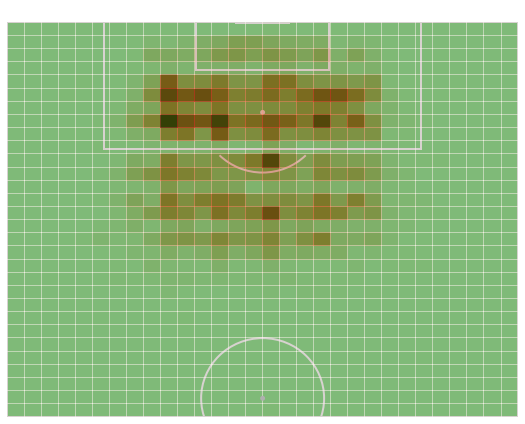

In [157]:
pitch = Pitch(figsize=(12, 6), orientation='vertical', view='half', pitch_color='green',
              pitch_type='wyscout')
pitch.draw()

plt.hist2d(shots['y'], 100 - shots['x'], range=[[0, 100], [50, 100]], bins=30,
           alpha=0.5, cmap=cm.Reds)
plt.title('Shots frequency', color='white')

plt.show()

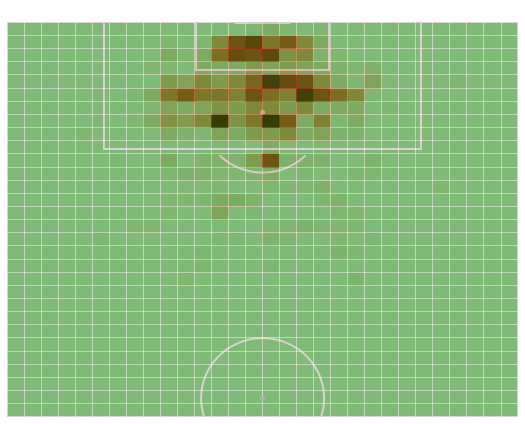

In [158]:
pitch = Pitch(figsize=(12, 6), orientation='vertical', view='half', pitch_color='green',
              pitch_type='wyscout')
pitch.draw()

plt.hist2d(shots.loc[shots['goal'] == 1, 'y'], 100 - shots.loc[shots['goal'] == 1, 'x'],
           range=[[0, 100], [50, 100]], bins=30,
           alpha=0.5, cmap=cm.Reds)
plt.title('Goals frequency', color='white')

plt.show()

How much angle and distance influence on the probability of scoring?

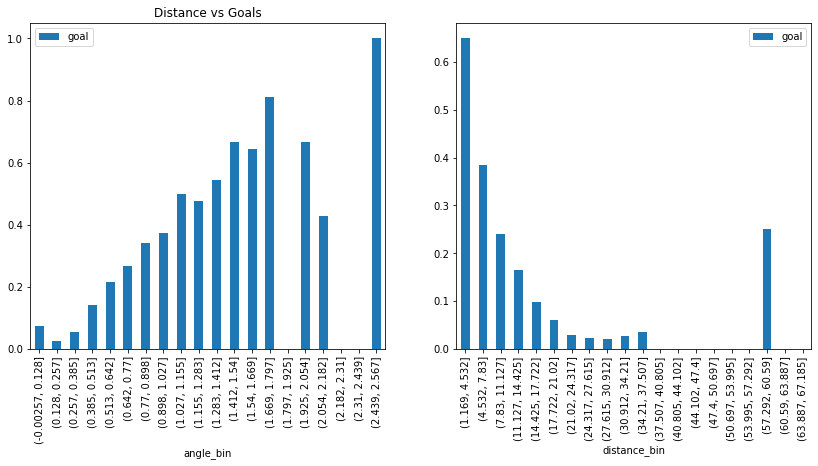

In [194]:
tmp = shots[['angle', 'goal', 'distance']]
tmp['angle_bin'] = pd.cut(shots['angle'], bins=20)
tmp['distance_bin'] = pd.cut(shots['distance'], bins=20)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
tmp.groupby('angle_bin').agg({'goal': 'mean'}).plot.bar(ax=ax[0])
ax[0].set_title('Angle vs Goals')

tmp.groupby('distance_bin').agg({'goal': 'mean'}).plot.bar(ax=ax[1])
ax[0].set_title('Distance vs Goals')

plt.show()

## Actual model

In [195]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [198]:
# Create bins for angle and probabilities
shotcount_dist=np.histogram(shots['angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(shots.loc[shots['goal'] == 1, 'angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2

<ipython-input-198-821f173b0ec8>:3: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


In [212]:
shotcount_dist=np.histogram(shots['distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(shots.loc[shots['goal'] == 1, 'distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2

<ipython-input-212-3791024c60c5>:3: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


At first, let's look only at Goal vs Angle

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7132
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2056.3
Date:                Sun, 11 Apr 2021   Deviance:                       4112.7
Time:                        11:45:05   Pearson chi2:                 6.70e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7097      0.085    -43.542      0.0

<ipython-input-213-182cf0c76591>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')


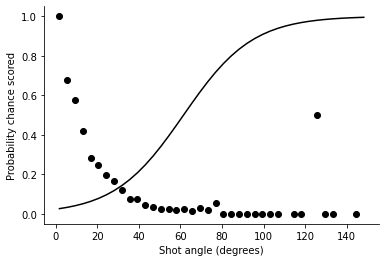

In [213]:
test_model = smf.glm(formula="goal ~ angle" , data=shots, 
                     family=sm.families.Binomial()).fit()
print(test_model.summary())  

b=test_model.params


xGprob=1/(1+np.exp(-(b[0]+b[1]*midangle*np.pi/180))) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Then only Distance VS Goal

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7132
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2010.7
Date:                Sun, 11 Apr 2021   Deviance:                       4021.3
Time:                        11:45:50   Pearson chi2:                 1.90e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5282      0.107      4.914      0.0

<ipython-input-215-e0455af7b718>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(middistance, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')


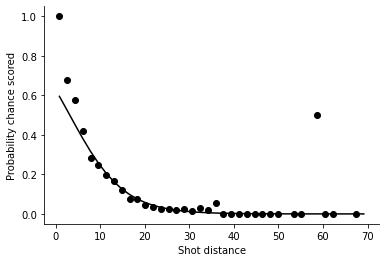

In [215]:
test_model = smf.glm(formula="goal ~ distance" , data=shots, 
                     family=sm.families.Binomial()).fit()
print(test_model.summary())  

b=test_model.params


xGprob=1/(1+np.exp(-(b[0]+b[1]*middistance))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(middistance, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot distance")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Finally, we use both features

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7131
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1990.9
Date:                Sun, 11 Apr 2021   Deviance:                       3981.8
Time:                        11:51:05   Pearson chi2:                 9.02e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8909      0.252     -3.532      0.0

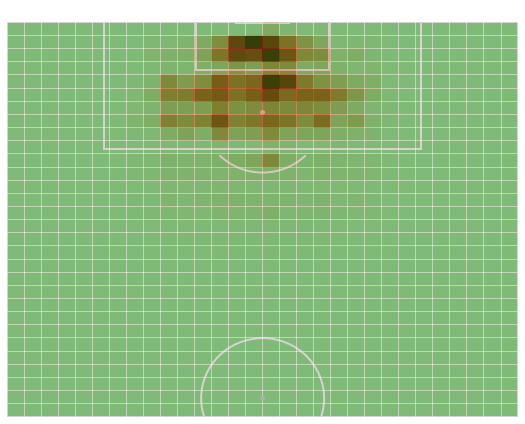

In [220]:
test_model = smf.glm(formula="goal ~ distance + angle" , data=shots, 
                     family=sm.families.Binomial()).fit()
print(test_model.summary())  

b=test_model.params
shots['xg_dist_angle'] = 1 / (1 + np.exp(-(b[0] + b[1] * shots['distance']
                                           + b[2] * shots['angle'])))

pitch = Pitch(figsize=(12, 6), orientation='vertical', view='half', pitch_color='green',
              pitch_type='wyscout')
pitch.draw()

plt.hist2d(shots['y'], 100 - shots['x'], weights=shots['xg_dist_angle'],
           range=[[0, 100], [50, 100]], bins=30,
           alpha=0.5, cmap=cm.Reds)
plt.title('XG on distance and angle', color='white')

plt.show()

And all available features

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7129
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1988.0
Date:                Sun, 11 Apr 2021   Deviance:                       3976.0
Time:                        11:52:33   Pearson chi2:                 9.33e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5114      0.305     -1.676      0.0

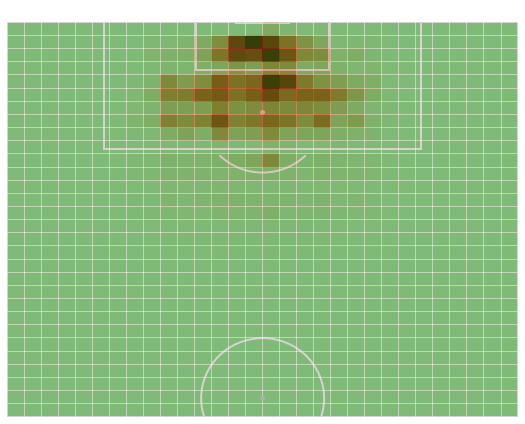

In [222]:
test_model = smf.glm(formula="goal ~ distance + angle + x_m + c_m" , data=shots, 
                     family=sm.families.Binomial()).fit()
print(test_model.summary())  

b=test_model.params
shots['xg_all'] = 1 / (1 + np.exp(-(b[0] + b[1] * shots['distance']
                                           + b[2] * shots['angle']
                                           + b[3] * shots['x_m']
                                           + b[4] * shots['c_m']
                                   )
                                 )
                      )

pitch = Pitch(figsize=(12, 6), orientation='vertical', view='half', pitch_color='green',
              pitch_type='wyscout')
pitch.draw()

plt.hist2d(shots['y'], 100 - shots['x'], weights=shots['xg_dist_angle'],
           range=[[0, 100], [50, 100]], bins=30,
           alpha=0.5, cmap=cm.Reds)
plt.title('XG on distance and angle', color='white')

plt.show()